## Clustering tree morphologies Using [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is pairwise bottleneck distances between persistence diagrams generated from sub-level set filtrations over neuronal trees. See [Kanari, L., Dłotko, P., Scolamiero, M. et al. A Topological Representation of Branching Neuronal Morphologies. Neuroinform 16, 3–13 (2018)](https://link.springer.com/article/10.1007/s12021-017-9341-1) for the general approach.

Before starting, we initialize Fiji with GUI support (see [Basic Example](basic_example.ipynb) for details on how to link your local Fiji installation to this notebook):

In [4]:
import ijfinder
import imagej
import os

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

The JVM is already running.


In [5]:
import time
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward

In [6]:
from jnius import autoclass, cast
Context = autoclass('org.scijava.Context')
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')
MultiTreeColorMapper = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [7]:
diagram_map = {}  # global
tree_map = {}     # global
labels = []       # global

In [8]:
def mydist(a1, a2):
    # bottleneck distance between two persistence diagrams
    # an epsilon may be specified, which greatly accelerates the computation
    return gd.bottleneck_distance(diagram_map[a1[0]], diagram_map[a2[0]]) 


def get_distance_matrix(cell_ids):
    M = pairwise_distances(cell_ids, metric=mydist)
    
    return M

    
def fetch_reconstructions():
    # Two types of mouse PT neuron from MOs with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA0011', 'AA0012', 'AA0115', 'AA0179', 'AA0180', 'AA0181', 'AA0182', 'AA0245', 
              'AA0250', 'AA0576', 'AA0726', 'AA0788', 'AA0791', 'AA0792']
    group_1 = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
              'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
              'AA0817', 'AA0837', 'AA0838', 'AA0844']
    groups = [group_0, group_1]
    trees = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            trees.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return trees
    
    
def compute(groups):
    cell_ids = []
    for tree in trees:  
        # Obtain Persistence Diagram as an nx2 array where each row corresponds
        # to one birth-death interval.
        diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram('geodesic')))
        key = int(tree.getLabel()[2:6])  # just the numeric part
        diagram_map[key] = diagram
        # necessary to pass a 2D numeric array to sklearn.metrics.pairwise_distances
        cell_ids.append([key])
    t0 = time.time()
    matrix = get_distance_matrix(cell_ids)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return matrix

In [9]:
trees = fetch_reconstructions()

In [10]:
matrix = compute(trees)

16.92231845855713  seconds to compute all distances


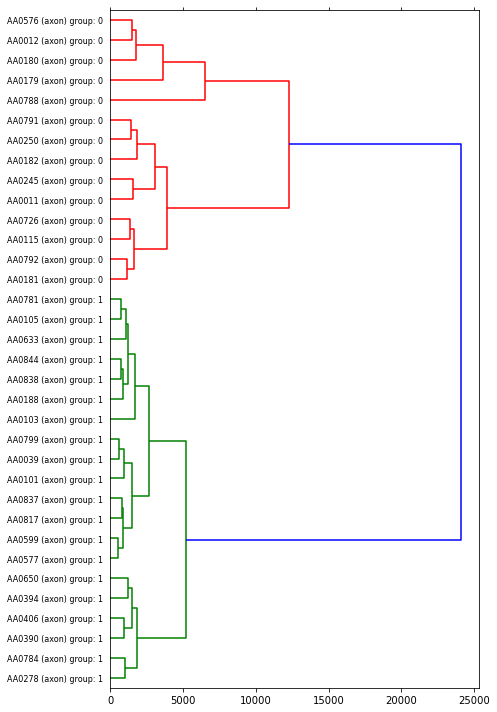

In [11]:
# Perform Hierarchical Clustering on the bottleneck distance matrix and plot a dendrogram
# of the resulting linkage matrix

# compensate for floating point errors in the bottleneck distance computation
np.fill_diagonal(matrix, 0) 
# convert to n-choose-2 dimensional vector to pass to linkage function
mat_arr = squareform(matrix)
linkage_matrix = ward(mat_arr) #define linkage_matrix using Ward's method

fig, ax = plt.subplots(figsize=(7, 10)) # set size
dendrogram(linkage_matrix, orientation='right', labels=labels) 
plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout()
#plt.savefig('ward_clusters.png', dpi=200)

Lets plot the two neighboring cells in each family

In [12]:
def get_group_viewers(compare):
    viewers = []
    for pair in compare:
        true_labels = []
        v = Viewer3D()
        for t in pair:
            v.addTree(tree_map[t])
            true_labels.append(tree_map[t].getLabel())
            
        v.colorCode(ij.py.to_java(true_labels), 
                    MultiTreeColorMapper.LENGTH, 
                    ColorTables.ICE)
        #v.setViewMode(Viewer3D.ViewMode.SIDE)
        viewers.append(v)
        
    return viewers

In [13]:
compare = [['AA0576', 'AA0012'], ['AA0784', 'AA0278']]
viewers = get_group_viewers(compare)  

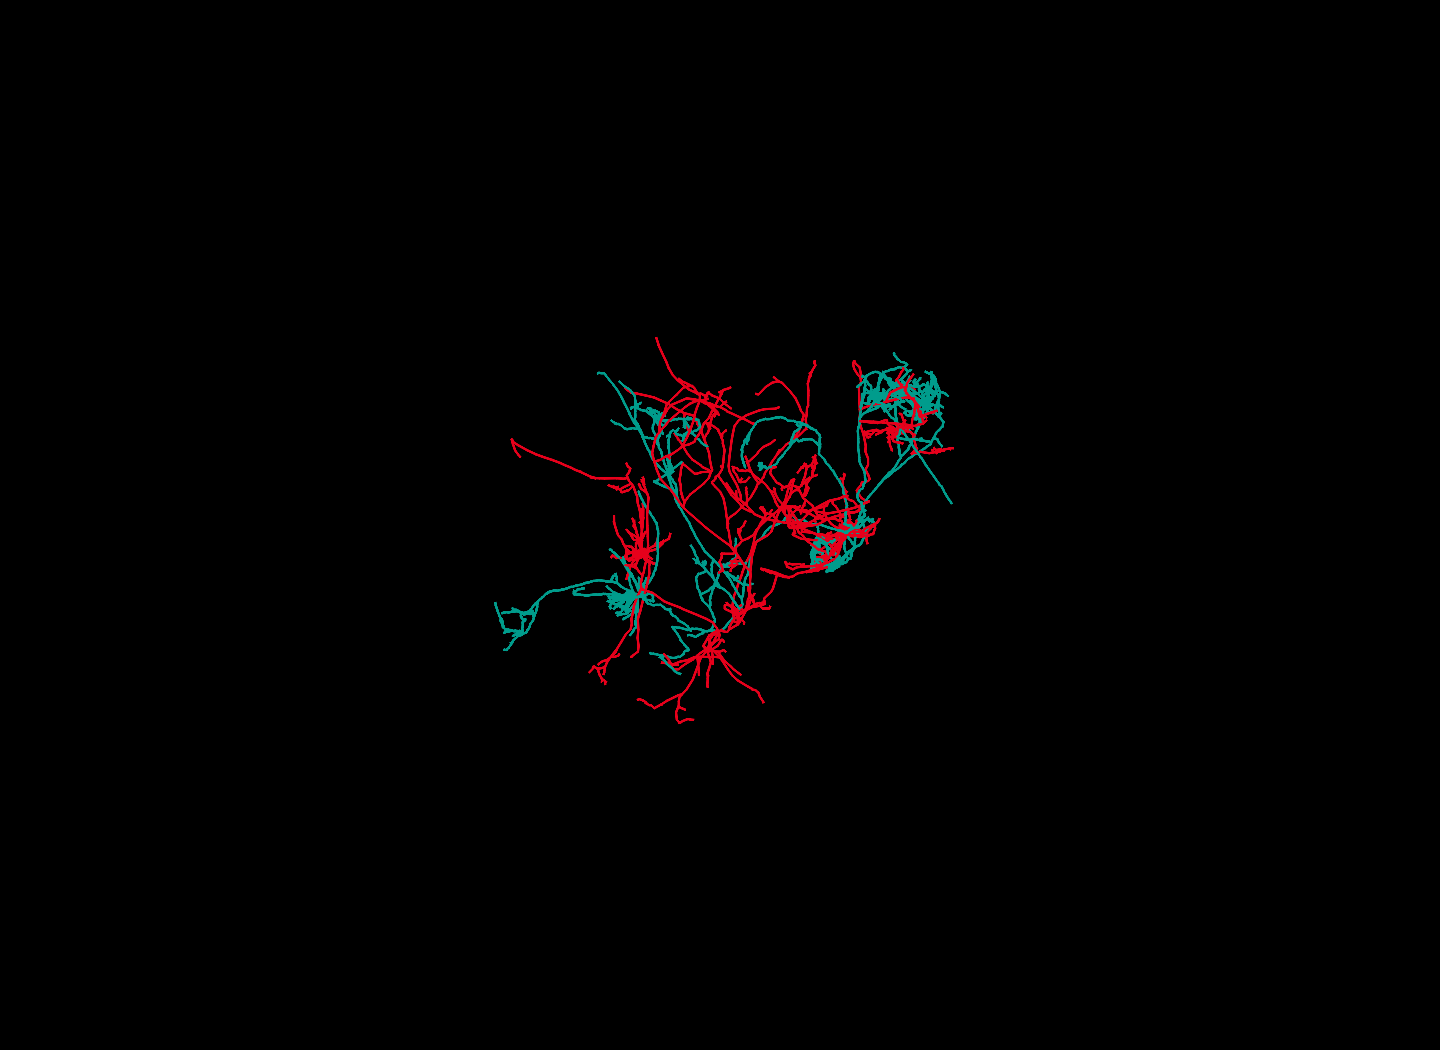

In [14]:
from IPython.display import Image, display
viewers[0].show()
snapshot_path = os.getcwd() + '/notebook-snapshots/recViewer-snapshot1.png'
viewers[0].saveSnapshot(snapshot_path)
# To embed the snapshot in this notebook
display(Image(filename=snapshot_path))

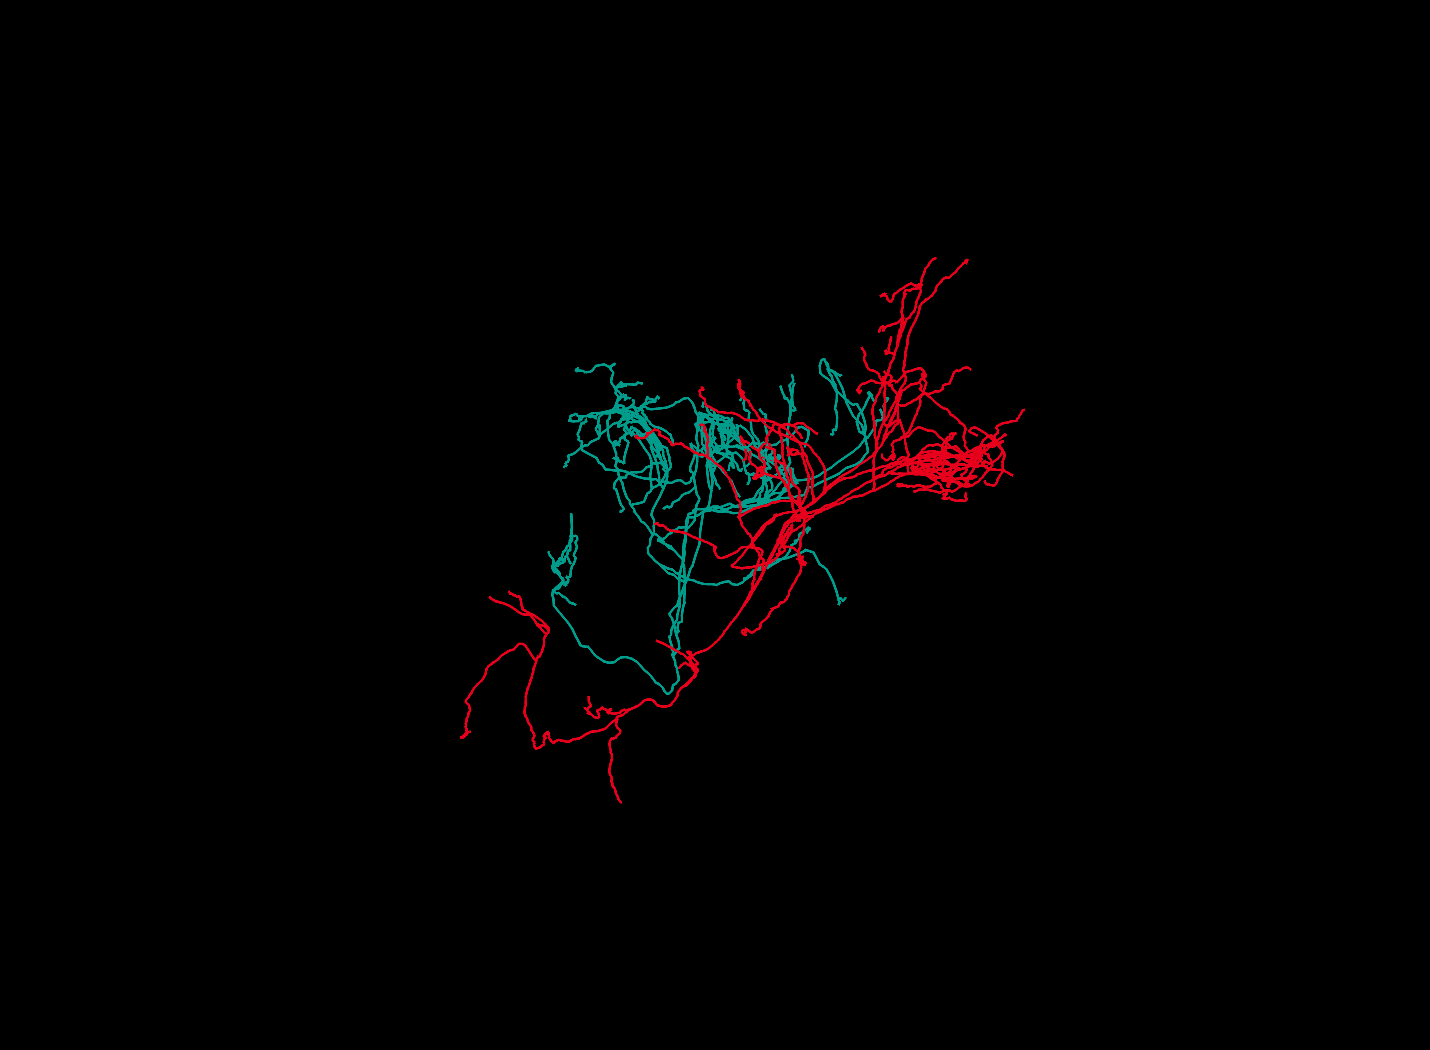

In [15]:
viewers[1].show()
snapshot_path = os.getcwd() + '/notebook-snapshots/recViewer-snapshot2.png'
viewers[1].saveSnapshot(snapshot_path)
display(Image(filename=snapshot_path))